In [1]:
import glob
import os
from itertools import combinations, product

import numpy as np
np.random.seed(18012023)

import pandas as pd
pd.set_option('display.max_colwidth', 0)

from sklearn.metrics import pairwise_distances
import lxml.etree
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from IPython.display import display

In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

In [2]:
meta_df = pd.read_excel('../data/metadata_corrected.xlsx')
meta_df = meta_df[meta_df['exclude'] != 'x']
meta_df.sample(10)

,id,title,author,date,provenance,date_range,genre,subgenre,exclude
204,Lutgard K,Sinte Lutgard,NaN,1267.5,CG1,1270-1265,Epiek,Heiligenleven,NaN
63,florigout_fragm_l,Florigout,NaN,1387.5,cdrom-mnl,1375-1400,Epiek,Ridder,NaN
111,loyhier_en_malaert_fragm_a,Loyhier en Malaert,NaN,1375.0,cdrom-mnl,1350-1400,Epiek,Karel,NaN
86,historie_van_gaver_capeel,Historie van Gaver Capeel,NaN,1510.0,cdrom-mnl,1500-1520,Epiek,Ridder,NaN
235,spiegel_historiael__4_velthem__fragm_l,Spiegel historiael (P4 [Velthem]),Lodewijk van Velthem,1350.0,cdrom-mnl,1340-1360,Epiek,Historiografie,NaN
153,ongeidentificeerd_6,Ongeïdentificeerd (6),NaN,1387.5,cdrom-mnl,1375-1400,Epiek,Karel,NaN
211,spiegel_der_sonden,Spiegel der sonden,NaN,1450.0,cdrom-mnl,1440-1460,Epiek,Didactiek,NaN
123,madelgijs_fragm_p,Madelgijs,NaN,1387.5,cdrom-mnl,1375-1400,Epiek,Karel,NaN
167,Reinout van Montalbaen,Reinout van Montalbaen,NaN,1288.0,CG1,1300-1276,Epiek,Karel,NaN
241,tien_plaghen,Tien plaghen ende die tien ghebode,NaN,1400.0,cdrom-mnl,1390-1410,Epiek,Didactiek,NaN


In [3]:
def get_verse_groups(verses, size=2, intertexts=False):
    for i in range(len(verses) - (size)):
        if not intertexts:
            yield ' '.join(verses[i : i + size] )
        else:
            # only keep first intertext encountered in verse group:
            yield verses[i]

In [4]:
GROUP_SIZE = 2

titles, tokens, lemmas, intertexts = [], [], [], []

for title, group in tqdm(meta_df.groupby('title')):
    work_tokens, work_lemmas, work_intertexts = [], [], []
    
    for id_ in sorted(group['id']):
        try:
            tree = lxml.etree.parse(f'../data/xml/{id_}.xml')
        except OSError:
            print(f'- Could not load {id_}')
            continue
        
        # don't remove interpolations?
        #for interpolation in tree.xpath("//interpolation"):
        #    interpolation.getparent().remove(interpolation)
        
        for line_node in tree.iterfind('//l'):
            try:
                intertext_id = line_node.attrib['intertext']
            except KeyError:
                intertext_id = None
            
            tokens_ = line_node.attrib['tokens'].split()
            lemmas_ = []
            
            lemma_tags = [l.text for l in line_node.iterfind('.//lemma')]
            pos_tags = [p.text for p in line_node.iterfind('.//pos')]
            
            for lemma, pos in zip(lemma_tags, pos_tags):
                for l, p in zip(lemma.split('+'), pos.split('+')):
                        if p == 'n(prop)':
                            lemmas_.append('n(prop)')
                        else:
                            lemmas_.append(l)
        
            work_tokens.append(tokens_)
            work_lemmas.append(lemmas_)
            work_intertexts.append(intertext_id)
    
    verse_tokens = [' '.join(v) for v in work_tokens]
    verse_lemmas = [' '.join(v) for v in work_lemmas]

    verse_group_tokens = list(get_verse_groups(verse_tokens, size=GROUP_SIZE))
    verse_group_lemmas = list(get_verse_groups(verse_lemmas, size=GROUP_SIZE))
    verse_group_intertexts = list(get_verse_groups(work_intertexts, size=GROUP_SIZE, intertexts=True))

    tokens.extend(verse_group_tokens)
    lemmas.extend(verse_group_lemmas)
    intertexts.extend(verse_group_intertexts)
    titles.extend([title] * len(verse_group_lemmas))

100%|██████████| 206/206 [00:32<00:00,  6.40it/s]


In [5]:
df = pd.DataFrame(zip(titles, tokens, lemmas, intertexts), columns=('title', 'tokens', 'lemmas', 'intertext'))
df[(df['title'] == 'Karel ende Elegast') & (~df['intertext'].isna())]

,title,tokens,lemmas,intertext
350340,Karel ende Elegast,Mach ic v tellen hoort naer Het was op enen auontstont,mogen ik gij tellen horen naar het zijn op een avondstond,mor-ele-1
350351,Karel ende Elegast,Crone draghen ende houden hof Om te meerderen sinen lof,kroon dragen en houden hof om te meerderen zijn lof,mor-ele-2
350352,Karel ende Elegast,Om te meerderen sinen lof Daer die coninc lach ende sliep,om te meerderen zijn lof daar de koning liggen en slapen,mor-ele-2
350372,Karel ende Elegast,Haestelic ende niet en spaert DIt verhoorde die coninc,haastelijk en niet ne sparen dit verhoren de koning,mor-ele-3
350394,Karel ende Elegast,En is man in aertrijcke Weder coninc noch grauen,en zijn man in aartrijke weder koning noch graven,mor-ele-4
...,...,...,...,...
351662,Karel ende Elegast,Al souts mi sijn te wors Nv sit weder op v ors,al zullen ik zijn te waars nu zitten weer op uw hors,mor-ele-78
351663,Karel ende Elegast,Nv sit weder op v ors Laet ons vechten ridder wise,nu zitten weer op uw hors laten wij vechten ridder wijs,mor-ele-78
351678,Karel ende Elegast,So fellen strijt tusschen hem tween Als si hadden al in een,zo fel strijd tussen zij twee als zij hebben al in een,mor-ele-79
351679,Karel ende Elegast,Als si hadden al in een Dats loghene ne geen,als zij hebben al in een dat het leugen ne geen,mor-ele-79


In [6]:
vec = TfidfVectorizer(max_features=10000, min_df=2, token_pattern=r"(?u)\b\w+\b")
X = vec.fit_transform(df['lemmas'])
X.shape

(924856, 10000)

In [7]:
sorted(df['title'].unique())

['AB recht ende averecht',
 'Alexanders geesten',
 'Alexiuslegende',
 'Anatomie van de mens',
 'Antwerps liedboek',
 'Arturs doet',
 'Aubri de Borgengoen',
 'Baghynken van Parys',
 'Barlaam en Josaphat',
 'Beatrijs',
 'Bediedenisse van der missen',
 'Beerte metten breden voeten',
 'Beginsel der oorlogen van Luyck',
 'Berlijnse liederenhandschrift',
 'Boec Exemplaer',
 'Boec van den houte',
 'Boec vander wraken',
 'Boeve van Hamtone',
 'Borchgrave van Couchi',
 'Borchgravinne van Vergi (1)',
 'Borchgravinne van Vergi (2)',
 'Boudewijn van Seborch',
 'Brabantsche yeesten (B1-5)',
 'Brabantsche yeesten (B6)',
 'Brabantsche yeesten (B7)',
 'Buskenblazer',
 "Chanson d'Aspremont",
 'Clausule vander bible',
 'Collectief lunarium I',
 'Collectief lunarium II',
 'Collectief lunarium III',
 'Commentaar op het Hooglied',
 'Cyromanchie van den pape van den Hamme',
 'Der kerken claghe',
 'Der leken spieghel',
 'Der mannen ende vrouwen heimelijcheit',
 'Der minnen loep',
 'Der naturen bloeme',
 'Der

In [8]:
def nearest_verses(title1, title2, base_df, vectorizer, prop_filt=2):
    A = base_df[base_df['title'] == title1]
    B = base_df[base_df['title'] == title2]
    
    AX = vec.transform(A['lemmas'])
    BX = vec.transform(B['lemmas'])
    
    nearest = []
    for i, ax in enumerate(AX):
        distances = pairwise_distances(ax, BX, metric='cosine').flatten()
        top_i = distances.argsort()[0]
        nearest.append((A.iloc[i]['tokens'], B.iloc[top_i]['tokens'],
                        A.iloc[i]['lemmas'], B.iloc[top_i]['lemmas'],
                        A.iloc[i]['title'], B.iloc[top_i]['title'],
                        A.iloc[i]['intertext'], B.iloc[top_i]['intertext'],
                        distances[top_i]))

    nearest = pd.DataFrame(nearest,
                           columns=['tokens1', 'tokens2', 'lemmas1', 'lemmas2',
                                    'title1', 'title2', 'intertext1', 'intertext2',
                                    'distance'])

    nearest = nearest[nearest['title1'] != nearest['title2']]
    nearest = nearest[
                      (nearest['lemmas1'].str.count('n\(prop\)') < prop_filt) & \
                      (nearest['lemmas1'].str.count('n\(prop\)') < prop_filt) 
                     ]
    return nearest

In [9]:
nearest_df = nearest_verses('Moriaen', 'Karel ende Elegast',
                            base_df=df, vectorizer=vec, prop_filt=2)
nearest_df = nearest_df.sort_values(by='distance')
nearest_df.head(50)

,tokens1,tokens2,lemmas1,lemmas2,title1,title2,intertext1,intertext2,distance
166,Nu es leden die derde dach Dat ic voer om min bejach,Dies is leden die derde dach Dat ic voer om mijn beiach,nu zijn lijden de derde dag dat ik varen om mijn bejag,die zijn lijden de derde dag dat ik varen om mijn bejag,Moriaen,Karel ende Elegast,mor-ele-44,mor-ele-44,0.044757
2924,Ende segt mi ende maect mi vroet Wat noetsaken dat u doet,In dien dat ghi mi maket vroet Wat nootsaken dat v doet,en zeggen ik en maken ik vroed wat noodzaak dat gij doen,in die dat gij ik maken vroed wat noodzaak dat uw doen,Moriaen,Karel ende Elegast,mor-ele-31,mor-ele-31,0.143453
196,Want ic come u te genaden Van allen minen mesdaden,Ic come v heden te ghenaden Van allen minen misdaden,want ik komen gij te genade van al mijn misdaad,ik komen gij heden te genade van al mijn misdaad,Moriaen,Karel ende Elegast,mor-ele-72,mor-ele-72,0.168456
2925,Wat noetsaken dat u doet Dat gi hier nu comt gereden,Wat nootsaken dat v doet Dat ghi hier quaemt te nacht,wat noodzaak dat gij doen dat gij hier nu komen rijden,wat noodzaak dat uw doen dat gij hier komen te nacht,Moriaen,Karel ende Elegast,mor-ele-31,mor-ele-31,0.232367
450,Dan mi een ridder dwingen soude Van dies ic doen nine woude,Dat mi een man dwinghen soude Van dinghen die ic niet en woude,dan ik een ridder dwingen zullen van die ik doen ne niet willen,dat ik een man dwingen zullen van ding die ik niet ne willen,Moriaen,Karel ende Elegast,mor-ele-22,mor-ele-22,0.241813
1852,Die grote ondaet ende die mort Hi sprac te sinen lieden vort,Dat ghi segt ende brenct voort Die ondaet ende die moort,de groot ondaad en de moord hij spreken te zijn lieden voort,dat gij zeggen en brengen voort de ondaad en de moord,Moriaen,Karel ende Elegast,mor-ele-70,mor-ele-70,0.250873
1298,Men doet mi lachter onverdient Quame enech Gods vrient,Dadi mi lachter onuerdient Ghi hadt verloren menigen vrient,men doen ik lachter onverdiend komen enig god vriend,doen ik lachter onverdiend gij hebben verliezen menig vriend,Moriaen,Karel ende Elegast,mor-ele-67,mor-ele-67,0.255512
882,Maer wistic uwer beider name Ende u wille ware ende bequame,Ick sel v segghen minen name Ist v wille ende bequame,maar ik weten uw beide naam en uw wil zijn en bekwaam,ik zullen gij zeggen mijn naam zijn het uw wil en bekwaam,Moriaen,Karel ende Elegast,mor-ele-38,mor-ele-38,0.279675
600,Secget mi u noetsaken Magic ic sal u vroet maken,In dien dat ghi mi maket vroet Wat nootsaken dat v doet,zeggen ik gij noodzaak ik mogen ik zullen gij vroed maken,in die dat gij ik maken vroed wat noodzaak dat uw doen,Moriaen,Karel ende Elegast,None,mor-ele-31,0.285998
900,U ne gesciets niet te wors Her Walewein sat doe op sijn ors,Al souts mi sijn te wors Nv sit weder op v ors,gij ne geschieden niet te waars heer n(prop) zitten toen op zijn hors,al zullen ik zijn te waars nu zitten weer op uw hors,Moriaen,Karel ende Elegast,mor-ele-78,mor-ele-78,0.293114


## Top-K

Limitation: assumes that you know the source quote!

In [10]:
meta = pd.read_excel('../data/intertexts.xlsx')
meta

,ID,source,src-passage,target,trg-passage,verse-length,biblio,remarks,Unnamed: 8
0,mor-ele-1,Moriaen,Dat magic v nv tellen,Karel ende Elegast,Mach ic v tellen,1,"Heeroma 1973a, Moriaen (I)",NaN,NaN
1,mor-ele-2,Moriaen,hilt hof Om te merre sinen lof.,Karel ende Elegast,houden hof Omme te meerne sinen lof:,2,"Heeroma 1973a, Moriaen (I)",NaN,NaN
2,mor-ele-3,Moriaen,Hastelike ende nine spard.,Karel ende Elegast,Haestelic ende niet en spaert:,1,"Heeroma 1973a, Moriaen (I)",NaN,NaN
3,mor-ele-4,Moriaen,Nv nes niweren in ertrike.,Karel ende Elegast,En es man in aertrijcke:,1,"Heeroma 1973a, Moriaen (I)",NaN,NaN
4,mor-ele-5,Moriaen,sine macht (es) so groet Ic waen men nigeren sine genoet Ne soude vinden.,Karel ende Elegast,Mijns selfs lant es soe groot Men vint nyewers sijns ghenoot:,3,"Heeroma 1973a, Moriaen (I)",NaN,NaN
...,...,...,...,...,...,...,...,...,...
106,mor-mou-25,Moriaen,Al soudire .VII. jaer licgen vore,Riddere metter mouwen,souden sire licgen .VII. jaer.,1,Van der Stempel 1939,NaN,NaN
107,mor-mou-26,Moriaen,Dat hi ware der bester een / Die den sonne nie besceen,Riddere metter mouwen,.. die beste riddere een / Die de sonne nie besceen.,1,Van der Stempel 1940,NaN,NaN
108,mor-mou-27,Moriaen,Ende hadde starke orsse bescreden / (: gereden),Riddere metter mouwen,Si hadden gode orsse bescreden / (: gereden),2,Van der Stempel 1941,NaN,NaN
109,mor-mou-28,Moriaen,Alse die bataelge was gedaen / Si hadden voles vele gevaen / Ende den coninc van Yrlant: / Het was hen wel gegaen in hant.,Riddere metter mouwen,Dattie coninc van Yrlant / Selve moeste gaen in hant / Ende liet hem den riddere vaen: / Doe was dat striden scire gedaen.,4,Van der Stempel 1942,NaN,NaN


In [11]:
relevant = meta[meta['ID'].str.startswith('mor-ele')]
relevant = relevant[relevant['verse-length'] > 1]
relevant

,ID,source,src-passage,target,trg-passage,verse-length,biblio,remarks,Unnamed: 8
1,mor-ele-2,Moriaen,hilt hof Om te merre sinen lof.,Karel ende Elegast,houden hof Omme te meerne sinen lof:,2,"Heeroma 1973a, Moriaen (I)",NaN,NaN
4,mor-ele-5,Moriaen,sine macht (es) so groet Ic waen men nigeren sine genoet Ne soude vinden.,Karel ende Elegast,Mijns selfs lant es soe groot Men vint nyewers sijns ghenoot:,3,"Heeroma 1973a, Moriaen (I)",NaN,NaN
7,mor-ele-8,Moriaen,Dier hi niet wilde laten achter Want hi wilde wreken den lachter,Karel ende Elegast,En wil ic niet laten achter Ic sel dief wesen al ist lachter,2,"Heeroma 1973a, Moriaen (I)",NaN,NaN
9,mor-ele-10,Moriaen,heide ende woest lant Daert mi was harde onbecant.,Karel ende Elegast,Moet varen in een lant Dat mi is vremde ende onbecant:,2,"Heeroma 1973a, Moriaen (I)",NaN,NaN
10,mor-ele-11,Moriaen,her walewein die dede gereden Sine wapine ende cleden.,Karel ende Elegast,Mit deser talen ghinc hem gereyden Die coninc karel ende cleyden:,2,"Heeroma 1973a, Moriaen (I)",NaN,NaN
14,mor-ele-15,Moriaen,met liste Daer mens nine sach no wiste.,Karel ende Elegast,daer icse wiste Die den lieden mit liste:,2,"Heeroma 1973a, Moriaen (I)",NaN,NaN
15,mor-ele-16,Moriaen,Banderside ane dander lant Dat hem was harde ombecant.,Karel ende Elegast,Beide borch ende lant Des was ic harde onbekant:,2,"Heeroma 1973a, Moriaen (I)",NaN,NaN
16,mor-ele-17,Moriaen,Si waenden allegader wel Dat ware die duuel ende niemen el.,Karel ende Elegast,Nochtan weet ic te voren wel Tis die duuel ende niemant el:,2,"Heeroma 1973a, Moriaen (I)",NaN,NaN
18,mor-ele-19,Moriaen,pensde in sinen sin Hi was vermant sere daer in.,Karel ende Elegast,Pensde hi in sinen sin Dese es verdoelt hier in:,2,"Heeroma 1973a, Moriaen (I)",NaN,NaN
19,mor-ele-20,Moriaen,Deen was een scone man Ende die wapine die hi droech an.,Karel ende Elegast,Ten was noyt arm man Die sulcke wapen droech an:,2,"Heeroma 1973a, Moriaen (I)",NaN,NaN


In [12]:
title1 = 'Moriaen'
title2 = 'Karel ende Elegast'

A = df[df['title'] == title1]
A = A[~A['intertext'].isna()]
A = A[A['intertext'].str.startswith('mor-ele')]
A = A.groupby('intertext').first()
A['intertext'] = A.index
A = A[A['intertext'].isin(relevant['ID'])]

B = df[df['title'] == title2]
    
AX = vec.transform(A['lemmas'])
BX = vec.transform(B['lemmas'])

K = 10
for k in range(1, K+1):
    print(':::::::::::')
    print(k)

    correct = 0

    for a, ax in zip(A.iterrows(), AX):
        #print("================")
        #print(a[1]['tokens'], a[1]['intertext'])
        distances = pairwise_distances(ax, BX, metric='cosine').flatten()
        top_k = distances.argsort()[:k]
        candidates = B.iloc[top_k].copy()
        candidates['distance'] = distances[top_k]
        if a[1]['intertext'] in set(candidates['intertext']):
            correct += 1
        #display(candidates)

    print(correct, '/', len(A))

:::::::::::
1
24 / 41
:::::::::::
2
31 / 41
:::::::::::
3
34 / 41
:::::::::::
4
35 / 41
:::::::::::
5
35 / 41
:::::::::::
6
35 / 41
:::::::::::
7
35 / 41
:::::::::::
8
35 / 41
:::::::::::
9
37 / 41
:::::::::::
10
37 / 41


In [13]:
AH = nearest_df[~nearest_df['intertext1'].isna()]
AH = AH[AH['intertext1'].str.startswith('mor-ele')]
AH.head(30)

,tokens1,tokens2,lemmas1,lemmas2,title1,title2,intertext1,intertext2,distance
166,Nu es leden die derde dach Dat ic voer om min bejach,Dies is leden die derde dach Dat ic voer om mijn beiach,nu zijn lijden de derde dag dat ik varen om mijn bejag,die zijn lijden de derde dag dat ik varen om mijn bejag,Moriaen,Karel ende Elegast,mor-ele-44,mor-ele-44,0.044757
2924,Ende segt mi ende maect mi vroet Wat noetsaken dat u doet,In dien dat ghi mi maket vroet Wat nootsaken dat v doet,en zeggen ik en maken ik vroed wat noodzaak dat gij doen,in die dat gij ik maken vroed wat noodzaak dat uw doen,Moriaen,Karel ende Elegast,mor-ele-31,mor-ele-31,0.143453
196,Want ic come u te genaden Van allen minen mesdaden,Ic come v heden te ghenaden Van allen minen misdaden,want ik komen gij te genade van al mijn misdaad,ik komen gij heden te genade van al mijn misdaad,Moriaen,Karel ende Elegast,mor-ele-72,mor-ele-72,0.168456
2925,Wat noetsaken dat u doet Dat gi hier nu comt gereden,Wat nootsaken dat v doet Dat ghi hier quaemt te nacht,wat noodzaak dat gij doen dat gij hier nu komen rijden,wat noodzaak dat uw doen dat gij hier komen te nacht,Moriaen,Karel ende Elegast,mor-ele-31,mor-ele-31,0.232367
450,Dan mi een ridder dwingen soude Van dies ic doen nine woude,Dat mi een man dwinghen soude Van dinghen die ic niet en woude,dan ik een ridder dwingen zullen van die ik doen ne niet willen,dat ik een man dwingen zullen van ding die ik niet ne willen,Moriaen,Karel ende Elegast,mor-ele-22,mor-ele-22,0.241813
1852,Die grote ondaet ende die mort Hi sprac te sinen lieden vort,Dat ghi segt ende brenct voort Die ondaet ende die moort,de groot ondaad en de moord hij spreken te zijn lieden voort,dat gij zeggen en brengen voort de ondaad en de moord,Moriaen,Karel ende Elegast,mor-ele-70,mor-ele-70,0.250873
1298,Men doet mi lachter onverdient Quame enech Gods vrient,Dadi mi lachter onuerdient Ghi hadt verloren menigen vrient,men doen ik lachter onverdiend komen enig god vriend,doen ik lachter onverdiend gij hebben verliezen menig vriend,Moriaen,Karel ende Elegast,mor-ele-67,mor-ele-67,0.255512
882,Maer wistic uwer beider name Ende u wille ware ende bequame,Ick sel v segghen minen name Ist v wille ende bequame,maar ik weten uw beide naam en uw wil zijn en bekwaam,ik zullen gij zeggen mijn naam zijn het uw wil en bekwaam,Moriaen,Karel ende Elegast,mor-ele-38,mor-ele-38,0.279675
900,U ne gesciets niet te wors Her Walewein sat doe op sijn ors,Al souts mi sijn te wors Nv sit weder op v ors,gij ne geschieden niet te waars heer n(prop) zitten toen op zijn hors,al zullen ik zijn te waars nu zitten weer op uw hors,Moriaen,Karel ende Elegast,mor-ele-78,mor-ele-78,0.293114
883,Ende u wille ware ende bequame Ic waers te blider sonder waen,Ist v wille ende bequame Ic ben ghehieten adelbrecht,en uw wil zijn en bekwaam ik zijn te blij zonder waan,zijn het uw wil en bekwaam ik zijn heten n(prop),Moriaen,Karel ende Elegast,mor-ele-38,mor-ele-38,0.330536


In [14]:
print(np.sum(AH['intertext1'] == AH['intertext2']), '/', len(AH))

48 / 126


## Threshold

In [15]:
#title1 = 'Karel ende Elegast'
#title2 = 'Moriaen'

A = df[df['title'] == title1]
B = df[df['title'] == title2]



In [16]:
relevant = meta[meta['ID'].str.startswith('mor-ele')]
relevant = relevant[relevant['verse-length'] > 1]
relevant

,ID,source,src-passage,target,trg-passage,verse-length,biblio,remarks,Unnamed: 8
1,mor-ele-2,Moriaen,hilt hof Om te merre sinen lof.,Karel ende Elegast,houden hof Omme te meerne sinen lof:,2,"Heeroma 1973a, Moriaen (I)",NaN,NaN
4,mor-ele-5,Moriaen,sine macht (es) so groet Ic waen men nigeren sine genoet Ne soude vinden.,Karel ende Elegast,Mijns selfs lant es soe groot Men vint nyewers sijns ghenoot:,3,"Heeroma 1973a, Moriaen (I)",NaN,NaN
7,mor-ele-8,Moriaen,Dier hi niet wilde laten achter Want hi wilde wreken den lachter,Karel ende Elegast,En wil ic niet laten achter Ic sel dief wesen al ist lachter,2,"Heeroma 1973a, Moriaen (I)",NaN,NaN
9,mor-ele-10,Moriaen,heide ende woest lant Daert mi was harde onbecant.,Karel ende Elegast,Moet varen in een lant Dat mi is vremde ende onbecant:,2,"Heeroma 1973a, Moriaen (I)",NaN,NaN
10,mor-ele-11,Moriaen,her walewein die dede gereden Sine wapine ende cleden.,Karel ende Elegast,Mit deser talen ghinc hem gereyden Die coninc karel ende cleyden:,2,"Heeroma 1973a, Moriaen (I)",NaN,NaN
14,mor-ele-15,Moriaen,met liste Daer mens nine sach no wiste.,Karel ende Elegast,daer icse wiste Die den lieden mit liste:,2,"Heeroma 1973a, Moriaen (I)",NaN,NaN
15,mor-ele-16,Moriaen,Banderside ane dander lant Dat hem was harde ombecant.,Karel ende Elegast,Beide borch ende lant Des was ic harde onbekant:,2,"Heeroma 1973a, Moriaen (I)",NaN,NaN
16,mor-ele-17,Moriaen,Si waenden allegader wel Dat ware die duuel ende niemen el.,Karel ende Elegast,Nochtan weet ic te voren wel Tis die duuel ende niemant el:,2,"Heeroma 1973a, Moriaen (I)",NaN,NaN
18,mor-ele-19,Moriaen,pensde in sinen sin Hi was vermant sere daer in.,Karel ende Elegast,Pensde hi in sinen sin Dese es verdoelt hier in:,2,"Heeroma 1973a, Moriaen (I)",NaN,NaN
19,mor-ele-20,Moriaen,Deen was een scone man Ende die wapine die hi droech an.,Karel ende Elegast,Ten was noyt arm man Die sulcke wapen droech an:,2,"Heeroma 1973a, Moriaen (I)",NaN,NaN


In [17]:
same_distances = []

for r in relevant['ID']:
    print('=============')
    print(r)
    As = A[A['intertext'] == r]
    Bs = B[B['intertext'] == r]
    display(As)
    display(Bs)
    
    AX = vec.transform(As['lemmas'])
    BX = vec.transform(Bs['lemmas'])
    
    same_distances.extend(pairwise_distances(AX, BX, metric='cosine').flatten())

mor-ele-2


,title,tokens,lemmas,intertext
464495,Moriaen,In Bertangen ende hilt hof Om te merre sinen lof,in n(prop) en houden hof om te meer zijn lof,mor-ele-2
464496,Moriaen,Om te merre sinen lof Ende daer die hoge liede saten,om te meer zijn lof en daar de hoog lieden zitten,mor-ele-2


,title,tokens,lemmas,intertext
350351,Karel ende Elegast,Crone draghen ende houden hof Om te meerderen sinen lof,kroon dragen en houden hof om te meerderen zijn lof,mor-ele-2
350352,Karel ende Elegast,Om te meerderen sinen lof Daer die coninc lach ende sliep,om te meerderen zijn lof daar de koning liggen en slapen,mor-ele-2


mor-ele-5


,title,tokens,lemmas,intertext
464677,Moriaen,Daer toe es sine macht so groet Ic waen men nigeren sine genoet,daar toe zijn zijn macht zo groot ik wanen men niegeren zijn genoot,mor-ele-5
464678,Moriaen,Ic waen men nigeren sine genoet Ne soude vinden in kerstenhede,ik wanen men niegeren zijn genoot ne zullen vinden in christenheid,mor-ele-5
464679,Moriaen,Ne soude vinden in kerstenhede Noch so goden riddere mede,ne zullen vinden in christenheid nog zo god ridder mede,mor-ele-5


,title,tokens,lemmas,intertext
350399,Karel ende Elegast,Mijn lant is so groot Men vint nyewers sijns ghenoot,mijn land zijn zo groot men vinden nieuwer zijn genoot,mor-ele-5
350400,Karel ende Elegast,Men vint nyewers sijns ghenoot Dlant is algader mijn,men vinden nieuwer zijn genoot het land zijn algader mijn,mor-ele-5


mor-ele-8


,title,tokens,lemmas,intertext
468056,Moriaen,Dier hi niet wilde laten achter Want hi wilde wreken den lachter,die hij niet willen laten achter want hij willen wreken de lachter,mor-ele-8
468057,Moriaen,Want hi wilde wreken den lachter Die onsen vader was gedaen,want hij willen wreken de lachter die ons vader zijn doen,mor-ele-8


,title,tokens,lemmas,intertext
350438,Karel ende Elegast,En wil ic niet laten achter Ic sel dief wesen al ist lachter,ne willen ik niet laten achter ik zullen dief wezen al zijn het lachter,mor-ele-8
350439,Karel ende Elegast,Ic sel dief wesen al ist lachter Al soudic hanghen bider kelen,ik zullen dief wezen al zijn het lachter al ik zullen hangen bij de keel,mor-ele-8


mor-ele-10


,title,tokens,lemmas,intertext
467219,Moriaen,Dan heide ende woest lant Daert mi was harde onbecant,dan heide en woest land daar het ik zijn harde onbekend,mor-ele-10
467220,Moriaen,Daert mi was harde onbecant In conster nieman gesien no horen,daar het ik zijn harde onbekend in konst niemand zien no horen,mor-ele-10


,title,tokens,lemmas,intertext
350466,Karel ende Elegast,Moet varen in een lant Dat mi is vremde ende onbecant,moeten varen in een land dat ik zijn vreemd en onbekend,mor-ele-10
350467,Karel ende Elegast,Dat mi is vremde ende onbecant Mit deser talen ghinc hem gereyden,dat ik zijn vreemd en onbekend met deze taal gaan hij gereden,mor-ele-10


mor-ele-11


,title,tokens,lemmas,intertext
467718,Moriaen,Ende her Walewein die dede gereden Sine wapine ende cleden,en heer n(prop) die doen rijden zijn wapen en kleden,mor-ele-11
467719,Moriaen,Sine wapine ende cleden Ende verscuren ende verclaren,zijn wapen en kleden en verschuren en verklaren,mor-ele-11


,title,tokens,lemmas,intertext
350468,Karel ende Elegast,Mit deser talen ghinc hem gereyden Die coninc karel ende cleyden,met deze taal gaan hij gereden de koning n(prop) en kleden,mor-ele-11
350469,Karel ende Elegast,Die coninc karel ende cleyden Mit sinen dieren gewaden,de koning n(prop) en kleden met zijn duur gewaad,mor-ele-11


mor-ele-15


,title,tokens,lemmas,intertext
466531,Moriaen,In Waleweins stegereep met liste Daer mens nine sach no wiste,in n(prop) steger met list daar het men ne niet zien no weten,mor-ele-15


,title,tokens,lemmas,intertext
350541,Karel ende Elegast,Dieue te hatene daer icse wiste Die den lieden mit liste,dief te haten daar ik zij weten die de lieden met list,mor-ele-15
350542,Karel ende Elegast,Die den lieden mit liste Hoer goet stelen ende rouen,die de lieden met list haar goed stelen en roven,mor-ele-15


mor-ele-16


,title,tokens,lemmas,intertext
465685,Moriaen,Banderside ane dander lant Dat hem was harde ombecant,banderzijde aan de ander land dat hij zijn harde onbekend,mor-ele-16
465686,Moriaen,Dat hem was harde ombecant Hoe een riddere quam gereden,dat hij zijn harde onbekend hoe een ridder komen rijden,mor-ele-16


,title,tokens,lemmas,intertext
350565,Karel ende Elegast,Beide borch ende lant Des was ic herde onbekant,beide burg en land dat zijn ik harden onbekend,mor-ele-16
350566,Karel ende Elegast,Des was ic herde onbekant Want hi hadde in sine scaren,dat zijn ik harden onbekend want hij hebben in zijn schare,mor-ele-16


mor-ele-17


,title,tokens,lemmas,intertext
466891,Moriaen,Si waenden allegader wel Dat ware di duvel ende niemen el,zij wanen algader wel dat zijn de duivel en niemand el,mor-ele-17
466892,Moriaen,Dat ware di duvel ende niemen el Die daer quamen opten sande,dat zijn de duivel en niemand el die daar komen de op zand,mor-ele-17


,title,tokens,lemmas,intertext
350631,Karel ende Elegast,Nochtan weet ic te voren wel Tis die duuel ende niemant el,nochtan weten ik te voren wel het is de duivel en niemand el,mor-ele-17
350632,Karel ende Elegast,Tis die duuel ende niemant el Waer hi van gods aluen yet,het is de duivel en niemand el zijn hij van god half iet,mor-ele-17


mor-ele-19


,title,tokens,lemmas,intertext
466349,Moriaen,Her Walewein pensde in sinen sin Hi was vermant sere daer in,heer n(prop) peinzen in zijn zin hij zijn vermanen zeer daar in,mor-ele-19
466350,Moriaen,Hi was vermant sere daer in Ende die van wapinen es bloet,hij zijn vermanen zeer daar in en die van wapen zijn bloed,mor-ele-19


,title,tokens,lemmas,intertext
350645,Karel ende Elegast,Pensde hi in sinen sin Dese is verdoelt hier in,peinzen hij in zijn zin deze zijn verdolen hier in,mor-ele-19
350646,Karel ende Elegast,Dese is verdoelt hier in Ende heuet sinen wech verloren,deze zijn verdolen hier in en hebben zijn weg verliezen,mor-ele-19


mor-ele-20


,title,tokens,lemmas,intertext
467996,Moriaen,Deen was een scone man Ende die wapine die hi droech an,de een zijn een schoon man en de wapen die hij dragen aan,mor-ele-20
467997,Moriaen,Ende die wapine die hi droech an Ende also was die ander mede,en de wapen die hij dragen aan en alzo zijn de ander mede,mor-ele-20


,title,tokens,lemmas,intertext
350655,Karel ende Elegast,Ten was noyt arm man Die sulcke wapen droech an,te de zijn nooit arm man die zulk wapen dragen aan,mor-ele-20
350656,Karel ende Elegast,Die sulcke wapen droech an Ende sulc ors hadde bescreden,die zulk wapen dragen aan en zulk hors hebben beschreien,mor-ele-20


mor-ele-21


,title,tokens,lemmas,intertext
464907,Moriaen,In soude jegen hem vechten Ofte hi soude mi berechten,in zullen jegen hij vechten of hij zullen ik berechten,mor-ele-21
464908,Moriaen,Ofte hi soude mi berechten Bericht mi ridder bi uwer trouwen,of hij zullen ik berechten berichten ik ridder bij uw trouw,mor-ele-21


,title,tokens,lemmas,intertext
350707,Karel ende Elegast,En wistu hoe berechten Ic heb lieuer dat wi vechten,en du willen hoe berechten ik hebben lief dat wij vechten,mor-ele-21
350708,Karel ende Elegast,Ic heb lieuer dat wi vechten Dan ic v seide bi bedwanghe,ik hebben lief dat wij vechten dan ik gij zeggen bij bedwang,mor-ele-21


mor-ele-22


,title,tokens,lemmas,intertext
464915,Moriaen,Dan mi een ridder dwingen soude Van dies ic doen nine woude,dan ik een ridder dwingen zullen van die ik doen ne niet willen,mor-ele-22
464916,Moriaen,Van dies ic doen nine woude Die lachter en gesciet mi heden,van die ik doen ne niet willen de lachter ne geschieden ik heden,mor-ele-22


,title,tokens,lemmas,intertext
350711,Karel ende Elegast,Dat mi een man dwinghen soude Van dinghen die ic niet en woude,dat ik een man dwingen zullen van ding die ik niet ne willen,mor-ele-22
350712,Karel ende Elegast,Van dinghen die ic niet en woude Berechten ten ware mi lief,van ding die ik niet ne willen berechten te de zijn ik lief,mor-ele-22


mor-ele-23


,title,tokens,lemmas,intertext
467319,Moriaen,Op een ors groet ende snel Ende hi was gewapent wel,op een hors groot en snel en hij zijn wapenen wel,mor-ele-23
467320,Moriaen,Ende hi was gewapent wel Ende sceen een starc riddere sijn,en hij zijn wapenen wel en schijnen een sterk ridder zijn,mor-ele-23


,title,tokens,lemmas,intertext
350723,Karel ende Elegast,Haer orssen sterc ende snel Si waren beyde ghewapent wel,haar orssen sterk en snel zij zijn beide gewapend wel,mor-ele-23
350724,Karel ende Elegast,Si waren beyde ghewapent wel Hare speeren waren sterc,zij zijn beide gewapend wel haar speer zijn sterk,mor-ele-23


mor-ele-25


,title,tokens,lemmas,intertext
465964,Moriaen,Dat si haer bloet sagen dure Tallen maelgen dringen uut,dat zij haar bloed zien door te al malk dringen uit,mor-ele-25
465965,Moriaen,Tallen maelgen dringen uut Ende die sparken sprongen uut,te al malk dringen uit en de spraak springen uit,mor-ele-25


,title,tokens,lemmas,intertext
350746,Karel ende Elegast,Daer en dranc dore dat bloet Doer die maelgien vuter huyt,daar ne drinken door dat bloed door de malengien uit de uit,mor-ele-25
350747,Karel ende Elegast,Doer die maelgien vuter huyt Daer van sloeghen groot gheluyt,door de malengien uit de uit daar van slaan groot geluid,mor-ele-25


mor-ele-31


,title,tokens,lemmas,intertext
467389,Moriaen,Ende segt mi ende maect mi vroet Wat noetsaken dat u doet,en zeggen ik en maken ik vroed wat noodzaak dat gij doen,mor-ele-31
467390,Moriaen,Wat noetsaken dat u doet Dat gi hier nu comt gereden,wat noodzaak dat gij doen dat gij hier nu komen rijden,mor-ele-31
467391,Moriaen,Dat gi hier nu comt gereden Ic wiste gerne die waerheden,dat gij hier nu komen rijden ik weten gaarne de waarheid,mor-ele-31


,title,tokens,lemmas,intertext
350799,Karel ende Elegast,In dien dat ghi mi maket vroet Wat nootsaken dat v doet,in die dat gij ik maken vroed wat noodzaak dat uw doen,mor-ele-31
350800,Karel ende Elegast,Wat nootsaken dat v doet Dat ghi hier quaemt te nacht,wat noodzaak dat uw doen dat gij hier komen te nacht,mor-ele-31
350801,Karel ende Elegast,Dat ghi hier quaemt te nacht Ende wiens toren dat ghi wacht,dat gij hier komen te nacht en wie toorn dat gij wachten,mor-ele-31


mor-ele-33


,title,tokens,lemmas,intertext
464623,Moriaen,Doe moestic varen achter lande Ic moets lien al eest scande,toen ik moeten varen achter land ik moeten lijden al het zijn schande,mor-ele-33
464624,Moriaen,Ic moets lien al eest scande Wie so quam in min gemoet,ik moeten lijden al het zijn schande wie zo komen in mijn gemoed,mor-ele-33


,title,tokens,lemmas,intertext
350851,Karel ende Elegast,Karel vut minen lande Ic salt segghen al ist scande,n(prop) uit mijn land ik het zullen zeggen al het zijn schande,mor-ele-33
350852,Karel ende Elegast,Ic salt segghen al ist scande So heb ic mi onthouden,ik het zullen zeggen al het zijn schande zo hebben ik ik onthouden,mor-ele-33


mor-ele-36


,title,tokens,lemmas,intertext
466285,Moriaen,Doe seide die here Hets min gast Ende hevet geleide goet ende vast,toen zeggen de heer het zijn mijn gast en hebben geleide goed en vast,mor-ele-36
466286,Moriaen,Ende hevet geleide goet ende vast Alse lange als hi hier binnen es,en hebben geleide goed en vast alzo lang als hij hier binnen zijn,mor-ele-36


,title,tokens,lemmas,intertext
350893,Karel ende Elegast,Sprac die coninc tot elegast Aen mi hebdi gheleyde vast,spreken de koning tot n(prop) aan ik hebben gij geleiden vast,mor-ele-36
350894,Karel ende Elegast,Aen mi hebdi gheleyde vast Ghestade vrient ende vrede,aan ik hebben gij geleiden vast gestade vriend en vrede,mor-ele-36


mor-ele-38


,title,tokens,lemmas,intertext
465347,Moriaen,Maer wistic uwer beider name Ende u wille ware ende bequame,maar ik weten uw beide naam en uw wil zijn en bekwaam,mor-ele-38
465348,Moriaen,Ende u wille ware ende bequame Ic waers te blider sonder waen,en uw wil zijn en bekwaam ik zijn te blij zonder waan,mor-ele-38


,title,tokens,lemmas,intertext
350905,Karel ende Elegast,Ick sel v segghen minen name Ist v wille ende bequame,ik zullen gij zeggen mijn naam zijn het uw wil en bekwaam,mor-ele-38
350906,Karel ende Elegast,Ist v wille ende bequame Ic ben ghehieten adelbrecht,zijn het uw wil en bekwaam ik zijn heten n(prop),mor-ele-38


mor-ele-39


,title,tokens,lemmas,intertext
465001,Moriaen,Ende hads u bericht geerne Dat wetic wel ende niet te seerne,en hebben het gij berichten gaarne dat ik weten wel en niet te zeren,mor-ele-39
465002,Moriaen,Dat wetic wel ende niet te seerne Gi sijt dul ende oec ries,dat ik weten wel en niet te zeren gij zijn dul en ook ries,mor-ele-39


,title,tokens,lemmas,intertext
350984,Karel ende Elegast,ELegast sede ia ic gerne Men weet niet ghi segt in scerne,ellages zede ja ik gaarne men weten niet gij zeggen in scheren,mor-ele-39
350985,Karel ende Elegast,Men weet niet ghi segt in scerne Theggericx van eggermonde,men weten niet gij zeggen in scheren n(prop) van n(prop),mor-ele-39


mor-ele-41


,title,tokens,lemmas,intertext
466471,Moriaen,Ende pensde in sinen moet Hem ware gene dinc so goet,en peinzen in zijn moed hij zijn geen ding zo goed,mor-ele-41
466472,Moriaen,Hem ware gene dinc so goet Alse hi den riddere late gaen,hij zijn geen ding zo goed als hij de ridder laten gaan,mor-ele-41


,title,tokens,lemmas,intertext
351020,Karel ende Elegast,Hi pensde in sinen moet Dit is den ambocht goet,hij peinzen in zijn moed dit zijn dat ambacht goed,mor-ele-41
351021,Karel ende Elegast,Dit is den ambocht goet Die grauen wil in borghen,dit zijn dat ambacht goed de graaf willen in borg,mor-ele-41


mor-ele-42


,title,tokens,lemmas,intertext
467155,Moriaen,Van al dien dat hen bedorste Ende dede hen halen sonder vorste,van al die dat zij bedorst en doen zij halen zonder voorst,mor-ele-42
467156,Moriaen,Ende dede hen halen sonder vorste Enen garsoen die hen diende,en doen zij halen zonder voorst een garsoen die zij dienen,mor-ele-42


,title,tokens,lemmas,intertext
351024,Karel ende Elegast,Sulcke dinc als hem bedorste Doe sat hi op al sonder vorste,zulk ding als hij bedorst toen zitten hij op al zonder voorst,mor-ele-42
351025,Karel ende Elegast,Doe sat hi op al sonder vorste Ende volchdde elegaste,toen zitten hij op al zonder voorst en volgen elecabest,mor-ele-42


mor-ele-44


,title,tokens,lemmas,intertext
464631,Moriaen,Nu es leden die derde dach Dat ic voer om min bejach,nu zijn lijden de derde dag dat ik varen om mijn bejag,mor-ele-44
464632,Moriaen,Dat ic voer om min bejach Een riddere quam in min gemoet,dat ik varen om mijn bejag een ridder komen in mijn gemoed,mor-ele-44


,title,tokens,lemmas,intertext
351068,Karel ende Elegast,Dies is leden die derde dach Dat ic voer om mijn beiach,die zijn lijden de derde dag dat ik varen om mijn bejag,mor-ele-44
351069,Karel ende Elegast,Dat ic voer om mijn beiach Daer moestic mijn yser laten,dat ik varen om mijn bejag daar ik moeten mijn ijzer laten,mor-ele-44


mor-ele-45


,title,tokens,lemmas,intertext
464576,Moriaen,Doe trac hi ut sire aluwire Een cruet dat was also goed,toen trekken hij uit zijn alwier een kruid dat zijn alzo goed,mor-ele-45
464577,Moriaen,Een cruet dat was also goed Dattet stelpte mans bloet,een kruid dat zijn alzo goed dat het stelpen man bloed,mor-ele-45


,title,tokens,lemmas,intertext
351101,Karel ende Elegast,Hi trac een cruyt vut eenen vate Ende deet binnen sinen monde,hij trekken een kruid uit een vat en doen het binnen zijn mond,mor-ele-45


mor-ele-49


,title,tokens,lemmas,intertext
465620,Moriaen,Al haddemen hem gegeven alt goet Datten coninc Arture toe horde,al hebben men hij geven al dat goed dat hij koning n(prop) toe horen,mor-ele-49
465621,Moriaen,Datten coninc Arture toe horde Hine hadde niet sine vorworde,dat hij koning n(prop) toe horen hij ne hebben niet zijn voorwaarde,mor-ele-49
465622,Moriaen,Hine hadde niet sine vorworde Gelogen noch sine tale,hij ne hebben niet zijn voorwaarde liegen noch zijn taal,mor-ele-49


,title,tokens,lemmas,intertext
351267,Karel ende Elegast,Al om tgoet dat elegast brochte Hine hadder niet langher gestaen,al om dat goed dat n(prop) brengen hij ne er hebben niet lang staan,mor-ele-49
351268,Karel ende Elegast,Hine hadder niet langher gestaen Hadt na hem moghen gaen,hij ne er hebben niet lang staan hebben het na hij mogen gaan,mor-ele-49


mor-ele-50


,title,tokens,lemmas,intertext
467611,Moriaen,Ende nemen oec tenen wive Maer met enen scarpen knive,en nemen ook te een wijf maar met een scherp knijf,mor-ele-50
467612,Moriaen,Maer met enen scarpen knive Motic noch tavont gehert wesen,maar met een scherp knijf ik moeten nog avond geëerd wezen,mor-ele-50


,title,tokens,lemmas,intertext
351284,Karel ende Elegast,Of doden met eenen kniue Daer hi leyt bi sinen wiue,of doden met een knijf daar hij liggen bij zijn wijf,mor-ele-50
351285,Karel ende Elegast,Daer hi leyt bi sinen wiue Dat en lietic om al dat gout,daar hij liggen bij zijn wijf dat een ik laten om al dat goud,mor-ele-50


mor-ele-53


,title,tokens,lemmas,intertext
465383,Moriaen,Ende blijft sijn gestade vrient Hine hadde quaets jegen u verdient,en blijven zijn gestade vriend hij ne hebben kwaad jegen gij verdienen,mor-ele-53
465384,Moriaen,Hine hadde quaets jegen u verdient Dit radic u harde wel,hij ne hebben kwaad jegen gij verdienen dit raden ik gij harde wel,mor-ele-53


,title,tokens,lemmas,intertext
351340,Karel ende Elegast,Die coninc peynsde dits mijn vrient Al heb ics qualic op hem verdient,de koning peinzen dit zijn mijn vriend al hebben het ik kwalijk op hij verdienen,mor-ele-53
351341,Karel ende Elegast,Al heb ics qualic op hem verdient Ic salt beteren mach ic leuen,al hebben het ik kwalijk op hij verdienen ik het zullen beteren mogen ik leven,mor-ele-53


mor-ele-55


,title,tokens,lemmas,intertext
467227,Moriaen,Dus dogedic pine om niet Maer soe wat dat mins gesciet,dus dogen ik pijn om niet maar zo wat dat ik geschieden,mor-ele-55
467228,Moriaen,Maer soe wat dat mins gesciet Na dien dat ic verhoren can,maar zo wat dat ik geschieden na die dat ik verhoren kunnen,mor-ele-55


,title,tokens,lemmas,intertext
351358,Karel ende Elegast,Elegast seyde wats mijns gheschiet En come voor den coninc niet,n(prop) zeggen wat zijn ik geschieden ne komen voor de koning niet,mor-ele-55
351359,Karel ende Elegast,En come voor den coninc niet Die coninc is te mi so gram,ne komen voor de koning niet de koning zijn te ik zo gram,mor-ele-55


mor-ele-58


,title,tokens,lemmas,intertext
466101,Moriaen,Daer hi vant enen casteel Sijn herte was sonder riveel,daar hij vinden een kasteel zijn hart zijn zonder rijvel,mor-ele-58
466102,Moriaen,Sijn herte was sonder riveel Van groten hongere ende van dorste,zijn hart zijn zonder rijvel van groot honger en van dorst,mor-ele-58
468864,Moriaen,Dus waren si snachs inden casteel Sonder spel ende enech riveel,dus zijn zij de de in kasteel zonder spel en enig rijvel,mor-ele-58
468865,Moriaen,Sonder spel ende enech riveel Si hilden hen te gadere vaste,zonder spel en enig rijvel zij houden zij te gader vast,mor-ele-58


,title,tokens,lemmas,intertext
351382,Karel ende Elegast,Voer tynghelem in sijn casteel Sijn herte was sonder riueel,voor n(prop) in zijn kasteel zijn hart zijn zonder rive,mor-ele-58
351383,Karel ende Elegast,Sijn herte was sonder riueel Datten die gheen wilde verraden,zijn hart zijn zonder rive dat hij die geen willen verraden,mor-ele-58


mor-ele-58


,title,tokens,lemmas,intertext
466101,Moriaen,Daer hi vant enen casteel Sijn herte was sonder riveel,daar hij vinden een kasteel zijn hart zijn zonder rijvel,mor-ele-58
466102,Moriaen,Sijn herte was sonder riveel Van groten hongere ende van dorste,zijn hart zijn zonder rijvel van groot honger en van dorst,mor-ele-58
468864,Moriaen,Dus waren si snachs inden casteel Sonder spel ende enech riveel,dus zijn zij de de in kasteel zonder spel en enig rijvel,mor-ele-58
468865,Moriaen,Sonder spel ende enech riveel Si hilden hen te gadere vaste,zonder spel en enig rijvel zij houden zij te gader vast,mor-ele-58


,title,tokens,lemmas,intertext
351382,Karel ende Elegast,Voer tynghelem in sijn casteel Sijn herte was sonder riueel,voor n(prop) in zijn kasteel zijn hart zijn zonder rive,mor-ele-58
351383,Karel ende Elegast,Sijn herte was sonder riueel Datten die gheen wilde verraden,zijn hart zijn zonder rive dat hij die geen willen verraden,mor-ele-58


mor-ele-60


,title,tokens,lemmas,intertext
466449,Moriaen,Ende tirst datmen sach Verbaren den sconen dach,en eerst het dat men zien verbaren de schoon dag,mor-ele-60
466450,Moriaen,Verbaren den sconen dach Ginc die here met sinen lieden,verbaren de schoon dag gaan de heer met zijn lieden,mor-ele-60


,title,tokens,lemmas,intertext
351394,Karel ende Elegast,Ter hoger tinnen blies den dach Diemen scone verbaren sach,de te hoog tinnen blazen de dag die men schoon verbranden zien,mor-ele-60
351395,Karel ende Elegast,Diemen scone verbaren sach Doen wert in wake menich man,die men schoon verbranden zien doen worden in wake menig man,mor-ele-60


mor-ele-61


,title,tokens,lemmas,intertext
467185,Moriaen,Daermen met scepen over voer Ende daer verlosic al dat boer,daar men met schepen over voor en daar verliezen zij al dat boor,mor-ele-61
467186,Moriaen,Ende daer verlosic al dat boer Vanden spore waert voert liep,en daar verliezen zij al dat boor van de spoor waarts voorts lopen,mor-ele-61


,title,tokens,lemmas,intertext
351398,Karel ende Elegast,Doe die coninc stelen voer Dat was hem een scone boer,toen de koning stelen voor dat zijn hij een schoon bore,mor-ele-61
351399,Karel ende Elegast,Dat was hem een scone boer Doe seynde karel die coninc,dat zijn hij een schoon bore toen zenden n(prop) de koning,mor-ele-61


mor-ele-62


,title,tokens,lemmas,intertext
465063,Moriaen,Het sal u costen u leven Ic sal u goden raet geven,het zullen gij kosten uw leven ik zullen gij god raad geven,mor-ele-62
465064,Moriaen,Ic sal u goden raet geven Secget mi u noetsaken,ik zullen gij god raad geven zeggen ik gij noodzaak,mor-ele-62


,title,tokens,lemmas,intertext
351410,Karel ende Elegast,Als te nemen sijn leuen Dat si hem goeden raet geuen,als te nemen zijn leven dat zij hij goed raad geven,mor-ele-62
351411,Karel ende Elegast,Dat si hem goeden raet geuen Dat hi behoude sijn eere,dat zij hij goed raad geven dat hij behouden zijn eer,mor-ele-62


mor-ele-64


,title,tokens,lemmas,intertext
465749,Moriaen,Hi sager comen menegen man Die hadden alle halsberge an,hij zager komen menig man die hebben al halsberg aan,mor-ele-64
465750,Moriaen,Die hadden alle halsberge an Si waren hem na binnen ere milen,die hebben al halsberg aan zij zijn hij na binnen een mijl,mor-ele-64


,title,tokens,lemmas,intertext
351440,Karel ende Elegast,Men dede ter poorten lx man Gewapent ende halsberch an,men doen de te poort 60 man wapenen en n(prop) aan,mor-ele-64
351441,Karel ende Elegast,Gewapent ende halsberch an Doen eggerics lieden quamen geuaren,wapenen en n(prop) aan doen n(prop) lieden komen varen,mor-ele-64


mor-ele-65


,title,tokens,lemmas,intertext
465741,Moriaen,Sach hi volc bi groten scaren Naden riddere comen gevaren,zien hij volk bij groot schare de na ridder komen varen,mor-ele-65
465742,Moriaen,Naden riddere comen gevaren Die dese joncfrouwe ontscaecte,de na ridder komen varen die deze jonkvrouw ontschaken,mor-ele-65


,title,tokens,lemmas,intertext
351442,Karel ende Elegast,Doen eggerics lieden quamen geuaren In tconincs houe met scaren,doen n(prop) lieden komen varen in de koning hof met schaar,mor-ele-65
351443,Karel ende Elegast,In tconincs houe met scaren Ontdede men die poorte wide,in de koning hof met schaar ontdoen men de poort wijd,mor-ele-65


mor-ele-66


,title,tokens,lemmas,intertext
466199,Moriaen,Dore die porten altemale Doe si quamen in die zale,door de poort altemaal toen zij komen in de zaal,mor-ele-66
466200,Moriaen,Doe si quamen in die zale Daer was volcs harde vele,toen zij komen in de zaal daar zijn volk harde veel,mor-ele-66


,title,tokens,lemmas,intertext
351458,Karel ende Elegast,Ende waende gaen in die sale Slootmen die poorten te male,en wanen gaan in de zaal sluiten men de poort te maal,mor-ele-66
351459,Karel ende Elegast,Slootmen die poorten te male Men vincken als dander dede,sluiten men de poort te maal men n(prop) als ander de doen,mor-ele-66


mor-ele-68


,title,tokens,lemmas,intertext
468782,Moriaen,Ende den coninc onsen here Behouden oec wel sine ere,en de koning ons heer behouden ook wel zijn eer,mor-ele-68
468783,Moriaen,Behouden oec wel sine ere Al es hi aldus nu gevaen,behouden ook wel zijn eer al zijn hij aldus nu vangen,mor-ele-68


,title,tokens,lemmas,intertext
351506,Karel ende Elegast,Ende sinen gherechten heere Om te behouden sijn eere,en zijn gerecht heer om te behouden zijn eer,mor-ele-68
351507,Karel ende Elegast,Om te behouden sijn eere Si voeren wech metter spoet,om te behouden zijn eer zij voeren weg de met spoed,mor-ele-68


mor-ele-69


,title,tokens,lemmas,intertext
465071,Moriaen,Nu manic u bi aldien Die ridderscaeps nu plien,nu ik manen gij bij al die de ridderschap nu plegen,mor-ele-69
465072,Moriaen,Die ridderscaeps nu plien Ende bi Waleweine oec te voren,de ridderschap nu plegen en bij walewein ook te voren,mor-ele-69


,title,tokens,lemmas,intertext
351532,Karel ende Elegast,Nv vermaen ic v bi alle dien Dies god van sonden plien,nu vermanen ik gij bij al die dat god van zonde plegen,mor-ele-69
351533,Karel ende Elegast,Dies god van sonden plien Dat ghi segt ende brenct voort,dat god van zonde plegen dat gij zeggen en brengen voort,mor-ele-69


mor-ele-70


,title,tokens,lemmas,intertext
466317,Moriaen,Die grote ondaet ende die mort Hi sprac te sinen lieden vort,de groot ondaad en de moord hij spreken te zijn lieden voort,mor-ele-70
466318,Moriaen,Hi sprac te sinen lieden vort Nu volget alle mire tale,hij spreken te zijn lieden voort nu volgen al mijn taal,mor-ele-70


,title,tokens,lemmas,intertext
351534,Karel ende Elegast,Dat ghi segt ende brenct voort Die ondaet ende die moort,dat gij zeggen en brengen voort de ondaad en de moord,mor-ele-70
351535,Karel ende Elegast,Die ondaet ende die moort Van eggeric die ghi hier siet,de ondaad en de moord van n(prop) die gij hier zien,mor-ele-70


mor-ele-72


,title,tokens,lemmas,intertext
464661,Moriaen,Want ic come u te genaden Van allen minen mesdaden,want ik komen gij te genade van al mijn misdaad,mor-ele-72
464662,Moriaen,Van allen minen mesdaden Die ic ter werelt nie gewrachte,van al mijn misdaad die ik de te wereld nie werken,mor-ele-72
464663,Moriaen,Die ic ter werelt nie gewrachte Waest in daden waest in gedochte,die ik de te wereld nie werken het zijn in daad het zijn in gedachte,mor-ele-72


,title,tokens,lemmas,intertext
351598,Karel ende Elegast,Ic come v heden te ghenaden Van allen minen misdaden,ik komen gij heden te genade van al mijn misdaad,mor-ele-72
351599,Karel ende Elegast,Van allen minen misdaden Die mi ye gheuel,van al mijn misdaad die ik ie gevallen,mor-ele-72
351600,Karel ende Elegast,Die mi ye gheuel Ic kenne mine misdaet wel,die ik ie gevallen ik kennen mijn misdaad wel,mor-ele-72


mor-ele-74


,title,tokens,lemmas,intertext
464553,Moriaen,Dat en mochte niet bederven Noch van genen wonden sterven,dat ne mogen niet bederven noch van geen wond sterven,mor-ele-74
464554,Moriaen,Noch van genen wonden sterven Doe seide di riddere dire lach,noch van geen wond sterven toen zeggen de ridder die liggen,mor-ele-74


,title,tokens,lemmas,intertext
351608,Karel ende Elegast,So dat ic niet en sterue Noch inden camp en bederue,zo dat ik niet ne sterven noch in de kamp in bederf,mor-ele-74
351609,Karel ende Elegast,Noch inden camp en bederue Ist dat mi die sonden niet en slaen,noch in de kamp in bederf zijn het dat ik de zonde niet ne slaan,mor-ele-74


mor-ele-78


,title,tokens,lemmas,intertext
465365,Moriaen,U ne gesciets niet te wors Her Walewein sat doe op sijn ors,gij ne geschieden niet te waars heer n(prop) zitten toen op zijn hors,mor-ele-78
465366,Moriaen,Her Walewein sat doe op sijn ors Ende her Lanceloet op dat sine,heer n(prop) zitten toen op zijn hors en heer n(prop) op dat zijn,mor-ele-78


,title,tokens,lemmas,intertext
351662,Karel ende Elegast,Al souts mi sijn te wors Nv sit weder op v ors,al zullen ik zijn te waars nu zitten weer op uw hors,mor-ele-78
351663,Karel ende Elegast,Nv sit weder op v ors Laet ons vechten ridder wise,nu zitten weer op uw hors laten wij vechten ridder wijs,mor-ele-78


mor-ele-79


,title,tokens,lemmas,intertext
467876,Moriaen,Dus sciden si onder hen tween Ende Gariet reet al in een,dus scheiden zij onder zij twee en n(prop) rijden al in een,mor-ele-79
467877,Moriaen,Ende Gariet reet al in een Tes hi ter scepingen quam,en n(prop) rijden al in een de hij de te scheping komen,mor-ele-79


,title,tokens,lemmas,intertext
351678,Karel ende Elegast,So fellen strijt tusschen hem tween Als si hadden al in een,zo fel strijd tussen zij twee als zij hebben al in een,mor-ele-79
351679,Karel ende Elegast,Als si hadden al in een Dats loghene ne geen,als zij hebben al in een dat het leugen ne geen,mor-ele-79


mor-ele-72


,title,tokens,lemmas,intertext
464661,Moriaen,Want ic come u te genaden Van allen minen mesdaden,want ik komen gij te genade van al mijn misdaad,mor-ele-72
464662,Moriaen,Van allen minen mesdaden Die ic ter werelt nie gewrachte,van al mijn misdaad die ik de te wereld nie werken,mor-ele-72
464663,Moriaen,Die ic ter werelt nie gewrachte Waest in daden waest in gedochte,die ik de te wereld nie werken het zijn in daad het zijn in gedachte,mor-ele-72


,title,tokens,lemmas,intertext
351598,Karel ende Elegast,Ic come v heden te ghenaden Van allen minen misdaden,ik komen gij heden te genade van al mijn misdaad,mor-ele-72
351599,Karel ende Elegast,Van allen minen misdaden Die mi ye gheuel,van al mijn misdaad die ik ie gevallen,mor-ele-72
351600,Karel ende Elegast,Die mi ye gheuel Ic kenne mine misdaet wel,die ik ie gevallen ik kennen mijn misdaad wel,mor-ele-72


In [18]:
diff_distances = []

for r in relevant['ID']:
    print('=============')
    print(r)
    As = A[A['intertext'] == r]
    Bs = B.sample(2)
    display(As)
    display(Bs)
    
    AX = vec.transform(As['lemmas'])
    BX = vec.transform(Bs['lemmas'])
    
    diff_distances.extend(pairwise_distances(AX, BX, metric='cosine').flatten())

mor-ele-2


,title,tokens,lemmas,intertext
464495,Moriaen,In Bertangen ende hilt hof Om te merre sinen lof,in n(prop) en houden hof om te meer zijn lof,mor-ele-2
464496,Moriaen,Om te merre sinen lof Ende daer die hoge liede saten,om te meer zijn lof en daar de hoog lieden zitten,mor-ele-2


,title,tokens,lemmas,intertext
350745,Karel ende Elegast,Daer en was halsberch gheen soe goet Daer en dranc dore dat bloet,daar en zijn n(prop) geen zo goed daar ne drinken door dat bloed,None
351006,Karel ende Elegast,Al hadden sijn suster gheuangen Si souden node laten hangeu,al hebben zijn zuster vangen zij zullen node laten n(prop),None


mor-ele-5


,title,tokens,lemmas,intertext
464677,Moriaen,Daer toe es sine macht so groet Ic waen men nigeren sine genoet,daar toe zijn zijn macht zo groot ik wanen men niegeren zijn genoot,mor-ele-5
464678,Moriaen,Ic waen men nigeren sine genoet Ne soude vinden in kerstenhede,ik wanen men niegeren zijn genoot ne zullen vinden in christenheid,mor-ele-5
464679,Moriaen,Ne soude vinden in kerstenhede Noch so goden riddere mede,ne zullen vinden in christenheid nog zo god ridder mede,mor-ele-5


,title,tokens,lemmas,intertext
351622,Karel ende Elegast,Scone mit sijnder rechter hant Seghende hi sijn ridders ghewant,schoon met zijn recht hand zegenen hij zijn ridder gewand,None
350728,Karel ende Elegast,Dat dorssen boghen ouer gaer been Manlic vingen si ten swaerde,dat de boog over gaar been manlijk vangen zij te de zwaard,None


mor-ele-8


,title,tokens,lemmas,intertext
468056,Moriaen,Dier hi niet wilde laten achter Want hi wilde wreken den lachter,die hij niet willen laten achter want hij willen wreken de lachter,mor-ele-8
468057,Moriaen,Want hi wilde wreken den lachter Die onsen vader was gedaen,want hij willen wreken de lachter die ons vader zijn doen,mor-ele-8


,title,tokens,lemmas,intertext
350588,Karel ende Elegast,Abden ende moniken Dekenen ende papen,abt en monnik deken en paap,None
350496,Karel ende Elegast,Den wachter ende den poortiere Die luttel wisten dat hoer heere,de wachter en de portier die luttel weten dat zij heer,None


mor-ele-10


,title,tokens,lemmas,intertext
467219,Moriaen,Dan heide ende woest lant Daert mi was harde onbecant,dan heide en woest land daar het ik zijn harde onbekend,mor-ele-10
467220,Moriaen,Daert mi was harde onbecant In conster nieman gesien no horen,daar het ik zijn harde onbekend in konst niemand zien no horen,mor-ele-10


,title,tokens,lemmas,intertext
350804,Karel ende Elegast,Segt mi tierst ic segh v dan Wat ic hier soecke ende iaghe,zeggen ik eerst het ik zeggen gij dan wat ik hier zoeken en jagen,None
350527,Karel ende Elegast,Oetmoedich god ende vader Aen v keer ic mi alle gader,ootmoedig god en vader aan gij keer ik ik al gader,None


mor-ele-11


,title,tokens,lemmas,intertext
467718,Moriaen,Ende her Walewein die dede gereden Sine wapine ende cleden,en heer n(prop) die doen rijden zijn wapen en kleden,mor-ele-11
467719,Moriaen,Sine wapine ende cleden Ende verscuren ende verclaren,zijn wapen en kleden en verschuren en verklaren,mor-ele-11


,title,tokens,lemmas,intertext
351334,Karel ende Elegast,Biden heere die mi ghewrochte Ic sel vorderen mijn gedochte,bij de heer die ik gewrocht ik zullen vorderen mijn gedachte,None
350620,Karel ende Elegast,Ende quam enen sonderlingen pat Dwers riden doer den woude,en komen een zonderling pad dwars rijden door de woud,None


mor-ele-15


,title,tokens,lemmas,intertext
466531,Moriaen,In Waleweins stegereep met liste Daer mens nine sach no wiste,in n(prop) steger met list daar het men ne niet zien no weten,mor-ele-15


,title,tokens,lemmas,intertext
351392,Karel ende Elegast,Hi hadde sijn wapen af ghedaen So was die wachter gestaen,hij hebben zijn wapen af doen zo zijn de wachter staan,mor-ele-59
350896,Karel ende Elegast,Ic sel v seggen mine sede Wat helpt vrienden verholen,ik zullen gij zeggen mijn zede wat helpen vriend verholen,mor-ele-37


mor-ele-16


,title,tokens,lemmas,intertext
465685,Moriaen,Banderside ane dander lant Dat hem was harde ombecant,banderzijde aan de ander land dat hij zijn harde onbekend,mor-ele-16
465686,Moriaen,Dat hem was harde ombecant Hoe een riddere quam gereden,dat hij zijn harde onbekend hoe een ridder komen rijden,mor-ele-16


,title,tokens,lemmas,intertext
351605,Karel ende Elegast,Doer v heylighe vijf wonden Die ghi ontfinct doer ons misdaet,door gij heilig vijf wond die gij ontvangen door wij misdaad,None
350764,Karel ende Elegast,Ende sloech enen slach so seere Opten helm dat hi booch,en slaan een slag zo zeer op de helm dat hij n(prop),None


mor-ele-17


,title,tokens,lemmas,intertext
466891,Moriaen,Si waenden allegader wel Dat ware di duvel ende niemen el,zij wanen algader wel dat zijn de duivel en niemand el,mor-ele-17
466892,Moriaen,Dat ware di duvel ende niemen el Die daer quamen opten sande,dat zijn de duivel en niemand el die daar komen de op zand,mor-ele-17


,title,tokens,lemmas,intertext
351158,Karel ende Elegast,Beloken tusschen minen tanden Bi mijnre weet dat mach mi anden,beluiken tussen mijn tand bij mijn wet dat mogen ik aan de,None
350700,Karel ende Elegast,Berechtes mi so doedi wale Ic wil weten wie ghi sijt,berichten ik zo doen gij wel ik willen weten wie gij zijn,None


mor-ele-19


,title,tokens,lemmas,intertext
466349,Moriaen,Her Walewein pensde in sinen sin Hi was vermant sere daer in,heer n(prop) peinzen in zijn zin hij zijn vermanen zeer daar in,mor-ele-19
466350,Moriaen,Hi was vermant sere daer in Ende die van wapinen es bloet,hij zijn vermanen zeer daar in en die van wapen zijn bloed,mor-ele-19


,title,tokens,lemmas,intertext
350675,Karel ende Elegast,Datti mi ofte mine Brenghen wilde in pine,dat du ik of mijn brengen willen in pijn,None
351534,Karel ende Elegast,Dat ghi segt ende brenct voort Die ondaet ende die moort,dat gij zeggen en brengen voort de ondaad en de moord,mor-ele-70


mor-ele-20


,title,tokens,lemmas,intertext
467996,Moriaen,Deen was een scone man Ende die wapine die hi droech an,de een zijn een schoon man en de wapen die hij dragen aan,mor-ele-20
467997,Moriaen,Ende die wapine die hi droech an Ende also was die ander mede,en de wapen die hij dragen aan en alzo zijn de ander mede,mor-ele-20


,title,tokens,lemmas,intertext
350475,Karel ende Elegast,Het waren die beste die ye man sach Als hi aldus ghewapent was,het zijn de best die ie man zien als hij aldus gewapend zijn,None
350631,Karel ende Elegast,Nochtan weet ic te voren wel Tis die duuel ende niemant el,nochtan weten ik te voren wel het is de duivel en niemand el,mor-ele-17


mor-ele-21


,title,tokens,lemmas,intertext
464907,Moriaen,In soude jegen hem vechten Ofte hi soude mi berechten,in zullen jegen hij vechten of hij zullen ik berechten,mor-ele-21
464908,Moriaen,Ofte hi soude mi berechten Bericht mi ridder bi uwer trouwen,of hij zullen ik berechten berichten ik ridder bij uw trouw,mor-ele-21


,title,tokens,lemmas,intertext
351440,Karel ende Elegast,Men dede ter poorten lx man Gewapent ende halsberch an,men doen de te poort 60 man wapenen en n(prop) aan,mor-ele-64
351063,Karel ende Elegast,Dus ghedaen en sach ic noyt gheen Beseghen tot sulcken sticken,dus doen ne zien ik nooit geen bezigen tot zulk stuk,None


mor-ele-22


,title,tokens,lemmas,intertext
464915,Moriaen,Dan mi een ridder dwingen soude Van dies ic doen nine woude,dan ik een ridder dwingen zullen van die ik doen ne niet willen,mor-ele-22
464916,Moriaen,Van dies ic doen nine woude Die lachter en gesciet mi heden,van die ik doen ne niet willen de lachter ne geschieden ik heden,mor-ele-22


,title,tokens,lemmas,intertext
351396,Karel ende Elegast,Doen wert in wake menich man Dien god den slaep seynde an,doen worden in wake menig man die god de slaap zenden aan,None
350657,Karel ende Elegast,Ende sulc ors hadde bescreden So sterc ende van scone leden,en zulk hors hebben beschreien zo sterk en van schoon lijden,None


mor-ele-23


,title,tokens,lemmas,intertext
467319,Moriaen,Op een ors groet ende snel Ende hi was gewapent wel,op een hors groot en snel en hij zijn wapenen wel,mor-ele-23
467320,Moriaen,Ende hi was gewapent wel Ende sceen een starc riddere sijn,en hij zijn wapenen wel en schijnen een sterk ridder zijn,mor-ele-23


,title,tokens,lemmas,intertext
351416,Karel ende Elegast,Het sel den menighen costen tleuen Ic sal ons goeden raet gheuen,het zullen de menig kost het leven ik zullen ons goed raad geven,None
351498,Karel ende Elegast,Hi liet leggen sijn ghereyde Sonder eenich langher beyden,hij laten leggen zijn gereide zonder enig lang beiden,None


mor-ele-25


,title,tokens,lemmas,intertext
465964,Moriaen,Dat si haer bloet sagen dure Tallen maelgen dringen uut,dat zij haar bloed zien door te al malk dringen uit,mor-ele-25
465965,Moriaen,Tallen maelgen dringen uut Ende die sparken sprongen uut,te al malk dringen uit en de spraak springen uit,mor-ele-25


,title,tokens,lemmas,intertext
350677,Karel ende Elegast,Teghen den coninc die ic ontrade Hi en lede te nacht sonder scade,tegen de koning die ik ontraden hij ne lid te nacht zonder schade,None
350841,Karel ende Elegast,Mer so vele isser an En steels geenen armen man,maar zo veel er zijn aan een steel geen arm man,None


mor-ele-31


,title,tokens,lemmas,intertext
467389,Moriaen,Ende segt mi ende maect mi vroet Wat noetsaken dat u doet,en zeggen ik en maken ik vroed wat noodzaak dat gij doen,mor-ele-31
467390,Moriaen,Wat noetsaken dat u doet Dat gi hier nu comt gereden,wat noodzaak dat gij doen dat gij hier nu komen rijden,mor-ele-31
467391,Moriaen,Dat gi hier nu comt gereden Ic wiste gerne die waerheden,dat gij hier nu komen rijden ik weten gaarne de waarheid,mor-ele-31


,title,tokens,lemmas,intertext
351531,Karel ende Elegast,Sijt willecomme in mijn hof Nv vermaen ic v bi alle dien,zijn n(prop) in mijn hof nu vermanen ik gij bij al die,None
351202,Karel ende Elegast,Vanden sadel ende tghewin Dan elegast keerde weder in,van de zaad en het gewijn dan n(prop) keren weer in,None


mor-ele-33


,title,tokens,lemmas,intertext
464623,Moriaen,Doe moestic varen achter lande Ic moets lien al eest scande,toen ik moeten varen achter land ik moeten lijden al het zijn schande,mor-ele-33
464624,Moriaen,Ic moets lien al eest scande Wie so quam in min gemoet,ik moeten lijden al het zijn schande wie zo komen in mijn gemoed,mor-ele-33


,title,tokens,lemmas,intertext
351008,Karel ende Elegast,Dus droeghen si ouereen Daer te varen onder hem tween,dus dragen zij overeen daar te varen onder hij twee,mor-ele-40
351076,Karel ende Elegast,Daer ict vant aen een ploech Elegast sprac het is goet genoech,daar het ik vinden aan een ploeg ellages spreken het zijn goed genoeg,None


mor-ele-36


,title,tokens,lemmas,intertext
466285,Moriaen,Doe seide die here Hets min gast Ende hevet geleide goet ende vast,toen zeggen de heer het zijn mijn gast en hebben geleide goed en vast,mor-ele-36
466286,Moriaen,Ende hevet geleide goet ende vast Alse lange als hi hier binnen es,en hebben geleide goed en vast alzo lang als hij hier binnen zijn,mor-ele-36


,title,tokens,lemmas,intertext
351332,Karel ende Elegast,Den coninc karel minen heere Die waerdich is alder eere,de koning n(prop) mijn heer die waardig zijn al de eer,None
350887,Karel ende Elegast,Dit is die man die ic begheerde Bouen alle die leuen op daerde,dit zijn de man die ik begeren boven al de leven op derde,None


mor-ele-38


,title,tokens,lemmas,intertext
465347,Moriaen,Maer wistic uwer beider name Ende u wille ware ende bequame,maar ik weten uw beide naam en uw wil zijn en bekwaam,mor-ele-38
465348,Moriaen,Ende u wille ware ende bequame Ic waers te blider sonder waen,en uw wil zijn en bekwaam ik zijn te blij zonder waan,mor-ele-38


,title,tokens,lemmas,intertext
351691,Karel ende Elegast,Die coninc hadt hem gegeuen Elegast die heuet verheuen,de koning hebben hij geven n(prop) die hebben verheffen,None
350810,Karel ende Elegast,Als ghi mi uwen name noemt Dies sijt seker ende vast,als gij ik uw naam noemen die zijn zeker en vast,None


mor-ele-39


,title,tokens,lemmas,intertext
465001,Moriaen,Ende hads u bericht geerne Dat wetic wel ende niet te seerne,en hebben het gij berichten gaarne dat ik weten wel en niet te zeren,mor-ele-39
465002,Moriaen,Dat wetic wel ende niet te seerne Gi sijt dul ende oec ries,dat ik weten wel en niet te zeren gij zijn dul en ook ries,mor-ele-39


,title,tokens,lemmas,intertext
351560,Karel ende Elegast,En moget ontseggen camp noch strijt Die verdachuaert inden crijt,ne mogen ontzeggen kamp noch strijd die n(prop) de in krijt,None
350492,Karel ende Elegast,Hi sadelet ende satter bouen Opt ors datmen mochte louen,hij zadelen en daar zetten boven op dat hors dat men mogen loven,None


mor-ele-41


,title,tokens,lemmas,intertext
466471,Moriaen,Ende pensde in sinen moet Hem ware gene dinc so goet,en peinzen in zijn moed hij zijn geen ding zo goed,mor-ele-41
466472,Moriaen,Hem ware gene dinc so goet Alse hi den riddere late gaen,hij zijn geen ding zo goed als hij de ridder laten gaan,mor-ele-41


,title,tokens,lemmas,intertext
351243,Karel ende Elegast,Ende eggeric sloech soe houde Die vrouwe voor nase ende mont,en n(prop) slaan zo houden de vrouw voor n(prop) en mond,None
351497,Karel ende Elegast,Als hi die nieumare hoorde Hi liet leggen sijn ghereyde,als hij de nieuwmaar horen hij laten leggen zijn gereide,None


mor-ele-42


,title,tokens,lemmas,intertext
467155,Moriaen,Van al dien dat hen bedorste Ende dede hen halen sonder vorste,van al die dat zij bedorst en doen zij halen zonder voorst,mor-ele-42
467156,Moriaen,Ende dede hen halen sonder vorste Enen garsoen die hen diende,en doen zij halen zonder voorst een garsoen die zij dienen,mor-ele-42


,title,tokens,lemmas,intertext
351099,Karel ende Elegast,Die hi proefde ter menigher stede Die was minlic ende mate,die hij proeven de te menig stad die zijn minnelijk en maat,None
351187,Karel ende Elegast,Die in die camer ware ghestaen Daer eggeric ende sijn wijf in lach,die in de kamer zijn staan daar n(prop) en zijn wijf in liggen,None


mor-ele-44


,title,tokens,lemmas,intertext
464631,Moriaen,Nu es leden die derde dach Dat ic voer om min bejach,nu zijn lijden de derde dag dat ik varen om mijn bejag,mor-ele-44
464632,Moriaen,Dat ic voer om min bejach Een riddere quam in min gemoet,dat ik varen om mijn bejag een ridder komen in mijn gemoed,mor-ele-44


,title,tokens,lemmas,intertext
350429,Karel ende Elegast,Dengel vanden paradise Sprac conincdoet als die wise,de engel van de paradijs spreken koningsdood als de wijs,None
350822,Karel ende Elegast,Mijn gheluc is so cranc Als dit die coninc verstoet,mijn geluk zijn zo krank als dit de koning verstaan,None


mor-ele-45


,title,tokens,lemmas,intertext
464576,Moriaen,Doe trac hi ut sire aluwire Een cruet dat was also goed,toen trekken hij uit zijn alwier een kruid dat zijn alzo goed,mor-ele-45
464577,Moriaen,Een cruet dat was also goed Dattet stelpte mans bloet,een kruid dat zijn alzo goed dat het stelpen man bloed,mor-ele-45


,title,tokens,lemmas,intertext
351479,Karel ende Elegast,Nv come voort dies begheere Als die coninc verstoet,nu komen voorts die begeren als de koning verstaan,None
350805,Karel ende Elegast,Wat ic hier soecke ende iaghe En derf niet riden bi daghe,wat ik hier zoeken en jagen en durven niet rijden bij dag,None


mor-ele-49


,title,tokens,lemmas,intertext
465620,Moriaen,Al haddemen hem gegeven alt goet Datten coninc Arture toe horde,al hebben men hij geven al dat goed dat hij koning n(prop) toe horen,mor-ele-49
465621,Moriaen,Datten coninc Arture toe horde Hine hadde niet sine vorworde,dat hij koning n(prop) toe horen hij ne hebben niet zijn voorwaarde,mor-ele-49
465622,Moriaen,Hine hadde niet sine vorworde Gelogen noch sine tale,hij ne hebben niet zijn voorwaarde liegen noch zijn taal,mor-ele-49


,title,tokens,lemmas,intertext
351159,Karel ende Elegast,Bi mijnre weet dat mach mi anden Oe loech elegast echt,bij mijn wet dat mogen ik aan de hoe lachen ellages echt,None
351406,Karel ende Elegast,Van eggheric van eggermonde Die comen sal in corter stonde,van n(prop) van n(prop) die komen zullen in kort stond,None


mor-ele-50


,title,tokens,lemmas,intertext
467611,Moriaen,Ende nemen oec tenen wive Maer met enen scarpen knive,en nemen ook te een wijf maar met een scherp knijf,mor-ele-50
467612,Moriaen,Maer met enen scarpen knive Motic noch tavont gehert wesen,maar met een scherp knijf ik moeten nog avond geëerd wezen,mor-ele-50


,title,tokens,lemmas,intertext
351308,Karel ende Elegast,Hi danckes oetmoedelike Gode van hemelrike,hij n(prop) ootmoediglijk god van hemelrijk,None
351386,Karel ende Elegast,Soude recht na rechte staen Noch stont die poorte ontdaen,zullen recht na recht staan nog staan de poort ontdoen,None


mor-ele-53


,title,tokens,lemmas,intertext
465383,Moriaen,Ende blijft sijn gestade vrient Hine hadde quaets jegen u verdient,en blijven zijn gestade vriend hij ne hebben kwaad jegen gij verdienen,mor-ele-53
465384,Moriaen,Hine hadde quaets jegen u verdient Dit radic u harde wel,hij ne hebben kwaad jegen gij verdienen dit raden ik gij harde wel,mor-ele-53


,title,tokens,lemmas,intertext
351427,Karel ende Elegast,Wisellen wel weeren Dbloet sel hem lopen ter sporen,wisselen wel zijn bloed de zullen hij lopen te de spoor,None
350649,Karel ende Elegast,Hi salder laten die wapen sijn Die die beste sijn in schine,hij er laten die wapen zijn die de best zijn in schijn,None


mor-ele-55


,title,tokens,lemmas,intertext
467227,Moriaen,Dus dogedic pine om niet Maer soe wat dat mins gesciet,dus dogen ik pijn om niet maar zo wat dat ik geschieden,mor-ele-55
467228,Moriaen,Maer soe wat dat mins gesciet Na dien dat ic verhoren can,maar zo wat dat ik geschieden na die dat ik verhoren kunnen,mor-ele-55


,title,tokens,lemmas,intertext
350474,Karel ende Elegast,Ten bedde daer hi lach Het waren die beste die ye man sach,de te bed daar hij liggen het zijn de best die ie man zien,None
351053,Karel ende Elegast,Si bonden hoer orssen snel Ende ghingen ten muere sonder gheluyt,zij binden haar orssin snel en gaan te de muur zonder geluid,None


mor-ele-58


,title,tokens,lemmas,intertext
466101,Moriaen,Daer hi vant enen casteel Sijn herte was sonder riveel,daar hij vinden een kasteel zijn hart zijn zonder rijvel,mor-ele-58
466102,Moriaen,Sijn herte was sonder riveel Van groten hongere ende van dorste,zijn hart zijn zonder rijvel van groot honger en van dorst,mor-ele-58
468864,Moriaen,Dus waren si snachs inden casteel Sonder spel ende enech riveel,dus zijn zij de de in kasteel zonder spel en enig rijvel,mor-ele-58
468865,Moriaen,Sonder spel ende enech riveel Si hilden hen te gadere vaste,zonder spel en enig rijvel zij houden zij te gader vast,mor-ele-58


,title,tokens,lemmas,intertext
350433,Karel ende Elegast,Het sal v namaels wesen lief Et deser talen voer dengel dan,het zullen gij namaals wezen lief eten deze taal voor de engel dan,None
350700,Karel ende Elegast,Berechtes mi so doedi wale Ic wil weten wie ghi sijt,berichten ik zo doen gij wel ik willen weten wie gij zijn,None


mor-ele-58


,title,tokens,lemmas,intertext
466101,Moriaen,Daer hi vant enen casteel Sijn herte was sonder riveel,daar hij vinden een kasteel zijn hart zijn zonder rijvel,mor-ele-58
466102,Moriaen,Sijn herte was sonder riveel Van groten hongere ende van dorste,zijn hart zijn zonder rijvel van groot honger en van dorst,mor-ele-58
468864,Moriaen,Dus waren si snachs inden casteel Sonder spel ende enech riveel,dus zijn zij de de in kasteel zonder spel en enig rijvel,mor-ele-58
468865,Moriaen,Sonder spel ende enech riveel Si hilden hen te gadere vaste,zonder spel en enig rijvel zij houden zij te gader vast,mor-ele-58


,title,tokens,lemmas,intertext
350389,Karel ende Elegast,Ist alfs ghedroch dat mi quelt Ende dit grote wonder telt,zijn het half gedragen dat ik kwellen en dit groot wonder tellen,None
351045,Karel ende Elegast,An v seluen moet al staen Elegast seide tis mi lief,aan gij zelf moeten al staan n(prop) zeggen dat de ik lief,None


mor-ele-60


,title,tokens,lemmas,intertext
466449,Moriaen,Ende tirst datmen sach Verbaren den sconen dach,en eerst het dat men zien verbaren de schoon dag,mor-ele-60
466450,Moriaen,Verbaren den sconen dach Ginc die here met sinen lieden,verbaren de schoon dag gaan de heer met zijn lieden,mor-ele-60


,title,tokens,lemmas,intertext
351447,Karel ende Elegast,Dedemen hoer cleeder of Men vant naest haren liue,doen men haar kleed of men vinden naast haar lijf,None
350829,Karel ende Elegast,Ende hoe ghi v gheneert By al dat god heuet weert,en hoe gij gij generen bij al dat god hebben zijn,None


mor-ele-61


,title,tokens,lemmas,intertext
467185,Moriaen,Daermen met scepen over voer Ende daer verlosic al dat boer,daar men met schepen over voor en daar verliezen zij al dat boor,mor-ele-61
467186,Moriaen,Ende daer verlosic al dat boer Vanden spore waert voert liep,en daar verliezen zij al dat boor van de spoor waarts voorts lopen,mor-ele-61


,title,tokens,lemmas,intertext
351096,Karel ende Elegast,Met hem deylen sijn ghewin Die coninc bleef buten elegast ginc in,met hij delen zijn gewin de koning blijven buiten n(prop) gaan in,None
350970,Karel ende Elegast,Hi pensde mochti keeren Behouden sijnder eeren,hij peinzen hij mogen keren behouden zijn eer,None


mor-ele-62


,title,tokens,lemmas,intertext
465063,Moriaen,Het sal u costen u leven Ic sal u goden raet geven,het zullen gij kosten uw leven ik zullen gij god raad geven,mor-ele-62
465064,Moriaen,Ic sal u goden raet geven Secget mi u noetsaken,ik zullen gij god raad geven zeggen ik gij noodzaak,mor-ele-62


,title,tokens,lemmas,intertext
351686,Karel ende Elegast,Na redene ende na rechte Elegast hadde een swaert,naar reden en na recht n(prop) hebben een zwaard,None
350936,Karel ende Elegast,Dat wi connen beiaghen Beyt hier ende het sal daghen,dat wij kunnen bejagen beide hier en het zullen dagen,None


mor-ele-64


,title,tokens,lemmas,intertext
465749,Moriaen,Hi sager comen menegen man Die hadden alle halsberge an,hij zager komen menig man die hebben al halsberg aan,mor-ele-64
465750,Moriaen,Die hadden alle halsberge an Si waren hem na binnen ere milen,die hebben al halsberg aan zij zijn hij na binnen een mijl,mor-ele-64


,title,tokens,lemmas,intertext
350443,Karel ende Elegast,Dat ic van hem houde te leene Beyde borch ende lant,dat ik van hij houden te leen beide burg en land,None
351497,Karel ende Elegast,Als hi die nieumare hoorde Hi liet leggen sijn ghereyde,als hij de nieuwmaar horen hij laten leggen zijn gereide,None


mor-ele-65


,title,tokens,lemmas,intertext
465741,Moriaen,Sach hi volc bi groten scaren Naden riddere comen gevaren,zien hij volk bij groot schare de na ridder komen varen,mor-ele-65
465742,Moriaen,Naden riddere comen gevaren Die dese joncfrouwe ontscaecte,de na ridder komen varen die deze jonkvrouw ontschaken,mor-ele-65


,title,tokens,lemmas,intertext
350470,Karel ende Elegast,Mit sinen dieren gewaden Als die te stelen was beraden,met zijn duur gewaad als die te stelen zijn beraden,None
350956,Karel ende Elegast,Dat ic den coninc dade scade Al heeft hi mi bi quaden rade,dat ik de koning doen schade al hebben hij ik bij kwaad raad,None


mor-ele-66


,title,tokens,lemmas,intertext
466199,Moriaen,Dore die porten altemale Doe si quamen in die zale,door de poort altemaal toen zij komen in de zaal,mor-ele-66
466200,Moriaen,Doe si quamen in die zale Daer was volcs harde vele,toen zij komen in de zaal daar zijn volk harde veel,mor-ele-66


,title,tokens,lemmas,intertext
351201,Karel ende Elegast,Hi hadde eer ontbeert der vrame Vanden sadel ende tghewin,hij hebben eer ontberen de vraam van de zaad en het gewijn,None
351607,Karel ende Elegast,Hebt heden mijns raet So dat ic niet en sterue,hebben heden mijn raad zo dat ik niet ne sterven,None


mor-ele-68


,title,tokens,lemmas,intertext
468782,Moriaen,Ende den coninc onsen here Behouden oec wel sine ere,en de koning ons heer behouden ook wel zijn eer,mor-ele-68
468783,Moriaen,Behouden oec wel sine ere Al es hi aldus nu gevaen,behouden ook wel zijn eer al zijn hij aldus nu vangen,mor-ele-68


,title,tokens,lemmas,intertext
351327,Karel ende Elegast,Elegast antwoerde ghereet Bi al dat god leuen liet,n(prop) antwoorden gereed bij al dat god leven laten,None
351024,Karel ende Elegast,Sulcke dinc als hem bedorste Doe sat hi op al sonder vorste,zulk ding als hij bedorst toen zitten hij op al zonder voorst,mor-ele-42


mor-ele-69


,title,tokens,lemmas,intertext
465071,Moriaen,Nu manic u bi aldien Die ridderscaeps nu plien,nu ik manen gij bij al die de ridderschap nu plegen,mor-ele-69
465072,Moriaen,Die ridderscaeps nu plien Ende bi Waleweine oec te voren,de ridderschap nu plegen en bij walewein ook te voren,mor-ele-69


,title,tokens,lemmas,intertext
351184,Karel ende Elegast,Doen wilde karel van danen riden Elegast die hiet hem ontbeiden,toen willen n(prop) van danen rijden n(prop) die heten hij ontbeiden,None
351643,Karel ende Elegast,Datti neder viel opt velt Vanden orsse op daerde,dat hij neder vallen het op veld van de orssen op derde,None


mor-ele-70


,title,tokens,lemmas,intertext
466317,Moriaen,Die grote ondaet ende die mort Hi sprac te sinen lieden vort,de groot ondaad en de moord hij spreken te zijn lieden voort,mor-ele-70
466318,Moriaen,Hi sprac te sinen lieden vort Nu volget alle mire tale,hij spreken te zijn lieden voort nu volgen al mijn taal,mor-ele-70


,title,tokens,lemmas,intertext
351259,Karel ende Elegast,Ende sprac sijn woert mit trouwe Dat si beyde sliepen vast,en spreken zijn woord met trouw dat zij beide slapen vast,None
351533,Karel ende Elegast,Dies god van sonden plien Dat ghi segt ende brenct voort,dat god van zonde plegen dat gij zeggen en brengen voort,mor-ele-69


mor-ele-72


,title,tokens,lemmas,intertext
464661,Moriaen,Want ic come u te genaden Van allen minen mesdaden,want ik komen gij te genade van al mijn misdaad,mor-ele-72
464662,Moriaen,Van allen minen mesdaden Die ic ter werelt nie gewrachte,van al mijn misdaad die ik de te wereld nie werken,mor-ele-72
464663,Moriaen,Die ic ter werelt nie gewrachte Waest in daden waest in gedochte,die ik de te wereld nie werken het zijn in daad het zijn in gedachte,mor-ele-72


,title,tokens,lemmas,intertext
350589,Karel ende Elegast,Dekenen ende papen Daer hise can betrapen,deken en paap daar hij zij kunnen betrapen,None
351320,Karel ende Elegast,Wat talen souder of wesen Ghi sout des rouwen ghenesen,wat taal zullen er of wezen gij zullen de rouw genezen,None


mor-ele-74


,title,tokens,lemmas,intertext
464553,Moriaen,Dat en mochte niet bederven Noch van genen wonden sterven,dat ne mogen niet bederven noch van geen wond sterven,mor-ele-74
464554,Moriaen,Noch van genen wonden sterven Doe seide di riddere dire lach,noch van geen wond sterven toen zeggen de ridder die liggen,mor-ele-74


,title,tokens,lemmas,intertext
351313,Karel ende Elegast,Daer hi leit bi sinen wiue Thof selde verstormen al,daar hij liggen bij zijn wijf het hof zullen verstormen al,None
350484,Karel ende Elegast,In vasten slape als god woude Dat dedi al door des conincs houde,in vast slaap als god willen dat doen hij al door de koning oud,None


mor-ele-78


,title,tokens,lemmas,intertext
465365,Moriaen,U ne gesciets niet te wors Her Walewein sat doe op sijn ors,gij ne geschieden niet te waars heer n(prop) zitten toen op zijn hors,mor-ele-78
465366,Moriaen,Her Walewein sat doe op sijn ors Ende her Lanceloet op dat sine,heer n(prop) zitten toen op zijn hors en heer n(prop) op dat zijn,mor-ele-78


,title,tokens,lemmas,intertext
351554,Karel ende Elegast,Ontfinc ict bloet vander vrouwen Doen liet hi den coninc scouwen,ontvangen het ik bloed de van vrouw toen laten hij de koning schouwen,None
351007,Karel ende Elegast,Si souden node laten hangeu Dus droeghen si ouereen,zij zullen node laten n(prop) dus dragen zij overeen,None


mor-ele-79


,title,tokens,lemmas,intertext
467876,Moriaen,Dus sciden si onder hen tween Ende Gariet reet al in een,dus scheiden zij onder zij twee en n(prop) rijden al in een,mor-ele-79
467877,Moriaen,Ende Gariet reet al in een Tes hi ter scepingen quam,en n(prop) rijden al in een de hij de te scheping komen,mor-ele-79


,title,tokens,lemmas,intertext
351004,Karel ende Elegast,Na dat daer ghescepen stoet Dat daer ware stelen goet,na dat daar scheppen staan dat daar zijn stelen goed,None
351659,Karel ende Elegast,Ic soude corten desen strijt En wil v niet te voete slaen,ik zullen korten deze strijd ne willen gij niet te voet slaan,None


mor-ele-72


,title,tokens,lemmas,intertext
464661,Moriaen,Want ic come u te genaden Van allen minen mesdaden,want ik komen gij te genade van al mijn misdaad,mor-ele-72
464662,Moriaen,Van allen minen mesdaden Die ic ter werelt nie gewrachte,van al mijn misdaad die ik de te wereld nie werken,mor-ele-72
464663,Moriaen,Die ic ter werelt nie gewrachte Waest in daden waest in gedochte,die ik de te wereld nie werken het zijn in daad het zijn in gedachte,mor-ele-72


,title,tokens,lemmas,intertext
351443,Karel ende Elegast,In tconincs houe met scaren Ontdede men die poorte wide,in de koning hof met schaar ontdoen men de poort wijd,mor-ele-65
350682,Karel ende Elegast,Biden heere die mi ghewrochte Hine ontrijt mi te nacht,bij de heer die ik gewrocht hij ne onttreden ik te nacht,None


In [19]:
ss = pd.Series(same_distances)
ds = pd.Series(diff_distances)

In [20]:
#s.plot.kde()
ds.mean()

0.956735133020091

In [22]:
ss.quantile(.25)

0.5972333202239748

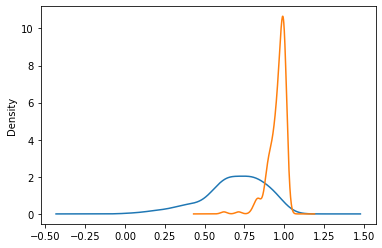

In [23]:
ax = ss.plot.kde()
ds.plot.kde(ax=ax);

In [24]:
cutoff = nearest_df[nearest_df['distance'] < .6]
cutoff
print(np.sum(nearest_df['intertext1'] == nearest_df['intertext2']), '/', len(cutoff))

48 / 1023


In [25]:
nearest_df[nearest_df['intertext1'] != nearest_df['intertext2']].head(30)

,tokens1,tokens2,lemmas1,lemmas2,title1,title2,intertext1,intertext2,distance
600,Secget mi u noetsaken Magic ic sal u vroet maken,In dien dat ghi mi maket vroet Wat nootsaken dat v doet,zeggen ik gij noodzaak ik mogen ik zullen gij vroed maken,in die dat gij ik maken vroed wat noodzaak dat uw doen,Moriaen,Karel ende Elegast,None,mor-ele-31,0.285998
3778,Doe pensdi in sinen moet Op dattie trappen waren so goet,Pensde hi in sinen moet Dat ick leue waer toe ist goet,toen hij peinzen in zijn moed op dat de n(prop) zijn zo goed,peinzen hij in zijn moed dat ik leven zijn toe zijn het goed,Moriaen,Karel ende Elegast,None,None,0.311042
628,Oft gi iet wet van Acglavale Nu laet ons corten dese tale,Hoe ghi hiet of wie ghi sijt Ende laet ons corten desen strijt,of gij iet weten van n(prop) nu laten wij korten deze taal,hoe gij iet of wie gij zijn en laten wij korten deze strijd,Moriaen,Karel ende Elegast,None,mor-ele-29,0.319563
2964,Si hadden daer soe grote macht Ende vingen Arture met harre cracht,Eggeric was van groter macht Ende alle die hadden cracht,zij hebben daar zo groot macht en vangen n(prop) met haar kracht,n(prop) zijn van groot macht en al die hebben kracht,Moriaen,Karel ende Elegast,None,None,0.321167
1651,Walewein seide Waerd u gebot Ende uwe wille ende bequame,Ist v wille ende bequame Ic ben ghehieten adelbrecht,n(prop) zeggen worden uw gebod en uw wil en bekwaam,zijn het uw wil en bekwaam ik zijn heten n(prop),Moriaen,Karel ende Elegast,None,mor-ele-38,0.323558
4413,Si waren binnen wel gereden Ende hadden starke orsse bescreden,Ende sulc ors hadde bescreden So sterc ende van scone leden,zij zijn binnen wel rijden en hebben sterk hors beschreien,en zulk hors hebben beschreien zo sterk en van schoon lijden,Moriaen,Karel ende Elegast,mor-mou-27,None,0.324152
2310,Ent hen lachter ware te vele Si souden hangen bider kele,Ic sel dief wesen al ist lachter Al soudic hanghen bider kelen,en het zij lachter zijn te veel zij zullen hangen bij de keel,ik zullen dief wezen al zijn het lachter al ik zullen hangen bij de keel,Moriaen,Karel ende Elegast,None,mor-ele-8,0.326903
1514,Al sachmer bloet drinken dore Sijn halsberch ontfinc gene score,Daer en was halsberch gheen soe goet Daer en dranc dore dat bloet,al er bloed drinken door zijn n(prop) ontvangen geen schore,daar en zijn n(prop) geen zo goed daar ne drinken door dat bloed,Moriaen,Karel ende Elegast,None,None,0.328970
2006,Ende pensde in sinen moet Hem ware gene dinc so goet,Ghi sijt te wapene so goet Die coninc pensde in sinen moet,en peinzen in zijn moed hij zijn geen ding zo goed,gij zijn te wapen zo goed de koning peinzen in zijn moed,Moriaen,Karel ende Elegast,mor-ele-41,None,0.336909
1436,Ende wel geboren vanden lande Ic moet secgen al eest scande,Karel vut minen lande Ic salt segghen al ist scande,en wel geboren van het land ik moeten zeggen al het zijn schande,n(prop) uit mijn land ik het zullen zeggen al het zijn schande,Moriaen,Karel ende Elegast,None,mor-ele-33,0.344239
